# Utilizando o Apache Cassandra

## Contexto

Este notebook visa implementar um modelo físico para uma feature de feedback de produtos e vendedores após compra em uma plataforma de e-commerce/recommerce, utilizando o DBMS [Apache Cassandra](https://cassandra.apache.org/). Simplificando o caso ao máximo, o modelo de dados conceitual poderia ser especificado da seguinte forma:

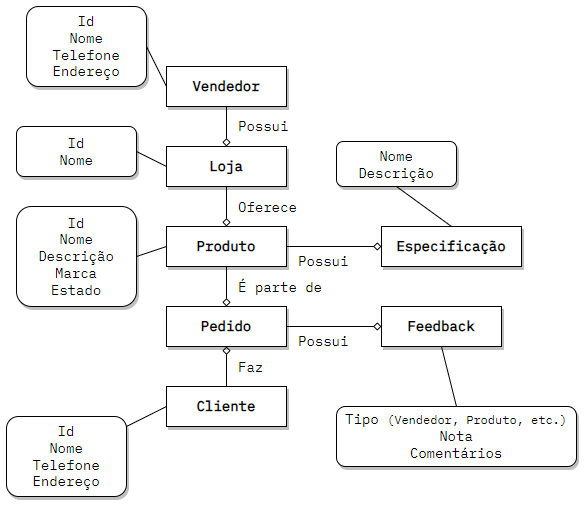

No entanto, o Cassandra é um DBMS NoSQL baseado em wide-columns. Ele é similar a um banco de dados relacional, mas os dados são estruturados de forma diferente. Suas características mais importantes são:
  * É um DBMS altamente disponível e escalável, os dados são particionados entre os nós com base em suas chaves primárias
  * Não há relacionamento (JOIN) entre tabelas, os dados são armazenados de forma destruturada

Por estas características, o modelo físico deve ser elaborado de acordo com as informações necessárias para cada consulta. Como os dados são destruturados, a duplicação de dados é uma prática recomendada para agilizar as consultas. Com isso, ele se torna extremamente simplificado:

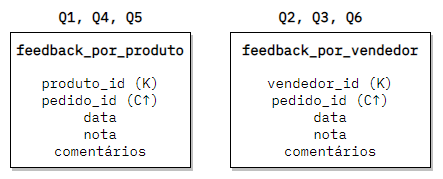

A seguir está o passo-a-passo para criar o *schema* físico e utilização das consultas.

## Criação da Keyspace

O campo abaixo consiste de um código Python para se conectar ao nó e criar o Keyspace na qual o schema e os dados fictícios serão criados.

In [ ]:
from cassandra.cluster import Cluster

cluster = Cluster(['localhost'], port = 9042)
session = cluster.connect()
session.execute('CREATE KEYSPACE IF NOT EXISTS brecho WITH REPLICATION = { \'class\' : \'SimpleStrategy\', \'replication_factor\' : \'1\' };')
session.execute('USE brecho;')

## Criação do schema

Dentro da Keystore, as duas tabelas especificadas no modelo físico são criadas.

In [ ]:
session.execute('DROP TABLE IF EXISTS feedback_por_produto')
session.execute('DROP TABLE IF EXISTS feedback_por_vendedor')
session.execute('CREATE TABLE IF NOT EXISTS feedback_por_produto(produto_id uuid, pedido_id uuid, data timestamp, nota double, comentarios text, PRIMARY KEY ((produto_id), pedido_id));')
session.execute('CREATE TABLE IF NOT EXISTS feedback_por_vendedor(vendedor_id uuid, pedido_id uuid, data timestamp, nota double, comentarios text, PRIMARY KEY ((vendedor_id), pedido_id));')

## Inserção dos dados

Com base nas tabelas criadas, uma quantidade de informação será gerada de forma a testar as consultas.

O código abaixo cria 50 produtos e 20 vendedores e, para cada produto e vendedor, de 100 a 500 avaliações são geradas. As avaliações possuem notas que variam de `0.5` a `5` e a data da avaliação é um momento aleatório nos últimos 2 anos.

A quantidade de avaliações, bem como as notas e datas são determinísticas, ou seja, os dados gerados serão iguais a cada execução.

In [ ]:
from datetime import date, datetime, timedelta
import lorem
import random
import uuid

random.seed("INF-325") #inicializa o seed para tornar o algoritmo determinístico

#trunca os dados das tabelas para sempre iniciar de um estado vazio
session.execute('TRUNCATE feedback_por_produto;')
session.execute('TRUNCATE feedback_por_vendedor;')

idProdutos = []
idVendedores = []

for p in range(50): #criando 50 produtos
    idProdutos.append(str(uuid.uuid4()))
    
for v in range(20): #criando 20 vendedores
    idVendedores.append(str(uuid.uuid4()))

#inclui registros de feedbacks de produtos
now = datetime.now()
totalRegistros = 0

#dentre os 50 produtos, cria uma quantia entre 100 e 500 avaliações por produto
print('Incluindo feedbacks de produtos')
insertQuery = 'INSERT INTO feedback_por_produto (produto_id, pedido_id, data, nota, comentarios) VALUES ({produto}, {pedido}, \'{data}\', {nota}, \'{comentarios}\');'
for ip in idProdutos:
    quantidade = random.randrange(100, 500)
    totalRegistros += quantidade
    print('Incluindo {} registros para o produto {}'.format(quantidade, ip))
          
    for x in range(quantidade):
        session.execute(insertQuery.format(produto = ip, pedido = str(uuid.uuid4()), data = datetime.utcnow() - timedelta(seconds = random.randrange(60 * 60 * 24 * 365 * 2)), nota = random.randrange(1, 11) * 0.5, comentarios = lorem.sentence()))

print('{} registros incluídos em {}s\n'.format(totalRegistros, (datetime.now() - now).total_seconds()))

#inclui registros de feedbacks de vendedores
now = datetime.now()
totalRegistros = 0

#dentre os 20 vendedores, cria uma quantia entre 100 e 500 avaliações por vendedor
print('Incluindo feedbacks de vendedores')
insertQuery = 'INSERT INTO feedback_por_vendedor (vendedor_id, pedido_id, data, nota, comentarios) VALUES ({vendedor}, {pedido}, \'{data}\', {nota}, \'{comentarios}\');'
for iv in idVendedores:
    quantidade = random.randrange(100, 500)
    totalRegistros += quantidade
    print('Incluindo {} registros para o vendedor {}'.format(quantidade, iv))
          
    for x in range(quantidade):
        session.execute(insertQuery.format(vendedor = iv, pedido = str(uuid.uuid4()), data = datetime.utcnow() - timedelta(seconds = random.randrange(60 * 60 * 24 * 365 * 2)), nota = random.randrange(1, 11) * 0.5, comentarios = lorem.sentence()))

print('{} registros incluídos em {}s'.format(totalRegistros, (datetime.now() - now).total_seconds()))

## Utilização das Consultas

Com o modelo físico gerado e populado, é possível utilizar as consultas propostas para filtrar os dados:

### Consulta 1

Qual é a avaliação média de um determinado produto?

Essa consulta pede um ID de produto como parâmetro. Para fins didáticos, o código itera sobre a lista de produtos inseridos anteriormente e calcula a média para cada um deles. Como as notas são baseadas em um gerador de números pseudo-aleatório, é de se esperar que as notas tenham uma distribuição normal entre `0.5` e `5`, por isso as médias serão semelhantes.

In [ ]:
query = 'SELECT AVG(nota) AS media_nota FROM feedback_por_produto WHERE produto_id = {};'
for ip in idProdutos:
    for res in session.execute(query.format(ip)):
        print('Produto: {}, Nota: {}'.format(ip, res.media_nota))

### Consulta 2

Qual é a avaliação média de um determinado vendedor?

Essa consulta pede um ID de vendedor como parâmetro. Para fins didáticos, o código itera sobre a lista de vendedores inseridos anteriormente e calcula a média para cada um deles.

In [ ]:
query = 'SELECT AVG(nota) AS media_nota FROM feedback_por_vendedor WHERE vendedor_id = {};'
for iv in idVendedores:
    for res in session.execute(query.format(iv)):
        print('Vendedor: {}, Nota: {}'.format(iv, res.media_nota))

### Consulta 3

Quais vendedores possuem a melhor avaliação média?

Neste caso temos um caso na qual o Cassandra não é capaz de resolver de forma escalável. Obter todos os registros de uma tabela já possui um impacto por si só, pois todas as partições devem ser percorridas. Além disso, não é possível ordenar pela média pois só é possível ordenar por campos que fazem parte da chave primária - e não há como uma agregação fazer parte da chave primária.

In [ ]:
rows = session.execute('SELECT vendedor_id, AVG(nota) AS media_nota FROM feedback_por_vendedor GROUP BY vendedor_id;')

resultado = []
for row in rows: resultado.append((row.vendedor_id, row.media_nota))

resultado.sort(reverse = True, key=lambda t: t[1])
for r in resultado: print('Vendedor: {}, Nota; {}'.format(r[0], r[1]))

### Consulta 4

Quais produtos possuem a melhor avaliação média?

Caso similar à Consulta 3.

In [ ]:
rows = session.execute('SELECT produto_id, AVG(nota) AS media_nota FROM feedback_por_produto GROUP BY produto_id;')

resultado = []
for row in rows: resultado.append((row.produto_id, row.media_nota))

resultado.sort(reverse = True, key=lambda t: t[1])
for r in resultado: print('Produto: {}, Nota; {}'.format(r[0], r[1]))

### Consulta 5

A partir de um produto, qual é o histograma de avaliações?

Para essa consulta, há um problema - é necessário agrupar os resultados pelas notas das avaliações (GROUP BY), mas o Cassandra permite apenas agrupamento por colunas que fazem parte da chave primária. Podemos resolver isso utilizando uma *Materialized View* com uma chave primária na qual a nota faz parte (como parte da chave de agrupamento, para o resultado ser ordenado).

No entanto, ao construir uma *view*, os dados são posteriormente filtrados e coletados, e esta operação não é atômica. Pode ser necessário executar as consultas abaixo duas vezes para ver os dados reais. Este problema poderia ser resolvido criando a *view* em conjunto com o *schema* das tabelas, mas está aqui para fins didáticos.

In [ ]:
session.execute('CREATE MATERIALIZED VIEW IF NOT EXISTS histograma_por_produto AS SELECT produto_id, pedido_id, nota FROM feedback_por_produto WHERE produto_id IS NOT NULL AND pedido_id IS NOT NULL AND nota IS NOT NULL PRIMARY KEY (produto_id, nota, pedido_id);')
print('Histograma de avaliações para o produto {}:\n'.format(idProdutos[0]))
rows = session.execute('SELECT nota, count(produto_id) as quant_notas FROM histograma_por_produto WHERE produto_id = {} GROUP BY nota;'.format(idProdutos[0]))
for row in rows:
    print("Nota: {}, Quantidade: {}".format(row.nota, row.quant_notas))

### Consulta 6

A partir de um vendedor, qual é o histograma de avaliações, considerando a média por semana?

Neste caso, a consulta se torna complexa - em bancos de dados relacionais geralmente há a possibilidade de particionar o resultado por critérios (OVER, PARTITION BY), funcionalidades que não existem no Cassandra atualmente. A solução neste caso é preparar o dado da melhor forma possível, e terminar o processamento na próxima camada - neste caso, no Python.

Esta consulta não é escalável - Como precisamos agrupar pela avaliação e filtrar pela data, é necessário que ambas as colunas façam parte da chave primária, mas isso não é possível em uma *Materialized View*, que só permite que uma coluna da tabela original faça parte da chave primária. A solução ideal nesse caso envolve repensar o modelo físico.

In [ ]:
session.execute('CREATE MATERIALIZED VIEW IF NOT EXISTS histograma_por_vendedor AS SELECT vendedor_id, pedido_id, data, nota FROM feedback_por_vendedor WHERE vendedor_id IS NOT NULL AND pedido_id IS NOT NULL AND data IS NOT NULL AND nota IS NOT NULL PRIMARY KEY (vendedor_id, nota, pedido_id);')

dataInicio = date.today() - timedelta(days = 7)
dataFim = date.today()
for i in range(10): #nas 10 ultimas semanas
    print("Semana: {} a {}".format(dataInicio, dataFim))
    
    rows = session.execute('SELECT nota, count(vendedor_id) as quant_notas FROM histograma_por_vendedor WHERE vendedor_id = {} AND data >= \'{}\' AND data < \'{}\' GROUP BY nota ALLOW FILTERING;'.format(idVendedores[0], dataInicio, dataFim))
    for row in rows:
        print("\tNota: {}, Quantidade: {}".format(row.nota, row.quant_notas))
    
    dataInicio -= timedelta(days = 7)
    dataFim -= timedelta(days = 7)